In [1]:
import gc
import os
import sys
import math
import random
import warnings
from tqdm import tqdm

import albumentations as A
import cv2
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import timm
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from pathlib import Path
from typing import List

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform
from sklearn import model_selection
from sklearn import metrics
from timm.models.layers import SelectAdaptivePool2d
from torch.optim.optimizer import Optimizer
from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation
import torchaudio

/home/user/.local/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
sys.path.append('../../')
import src.utils as utils
from config_ import CFG

## Data Loading

In [3]:
SUBMISSION = False

In [4]:
if SUBMISSION:
    DATA_DIR = Path("../input/")
    OUTPUT_DIR = Path("")
else:
    DATA_DIR = Path("/home/knikaido/work/BirdCLEF2021/data/")
    OUTPUT_DIR = Path('./output/')
MAIN_DATA_DIR = DATA_DIR / 'birdclef-2021'

TEST = (len(list((MAIN_DATA_DIR / "test_soundscapes/").glob("*.ogg"))) != 0)
if TEST:
    DATADIR = MAIN_DATA_DIR / "test_soundscapes/"
else:
    DATADIR = MAIN_DATA_DIR / "train_soundscapes/"

In [5]:
all_audios = list(DATADIR.glob("*.ogg"))
all_audio_ids = ["_".join(audio_id.name.split("_")[:2]) for audio_id in all_audios]
submission_df = pd.DataFrame({
    "row_id": all_audio_ids
})
submission_df

,row_id
0,57610_COR
1,2782_SSW
2,26709_SSW
3,42907_SSW
4,14473_SSW
5,54955_SSW
6,31928_COR
7,28933_SSW
8,21767_COR
9,18003_COR


## Test Dataset

In [6]:
class TestDataset(torchdata.Dataset):
    def __init__(self, df: pd.DataFrame, clip: np.ndarray,
                 waveform_transforms=None):
        self.df = df
        self.clip = clip
        self.waveform_transforms=waveform_transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        SR = CFG.sample_rate
        sample = self.df.loc[idx, :]
        row_id = sample.row_id

        end_seconds = int(sample.seconds)
        start_seconds = int(end_seconds - 5)

        start_index = SR * start_seconds
        end_index = SR * end_seconds

        y = self.clip[start_index:end_index].astype(np.float32)

        y = np.nan_to_num(y)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)

        y = np.nan_to_num(y)

        return y, row_id

In [7]:
def get_transforms(phase: str):
    transforms = CFG.transforms
    if transforms is None:
        return None
    else:
        if transforms[phase] is None:
            return None
        trns_list = []
        for trns_conf in transforms[phase]:
            trns_name = trns_conf["name"]
            trns_params = {} if trns_conf.get("params") is None else \
                trns_conf["params"]
            if globals().get(trns_name) is not None:
                trns_cls = globals()[trns_name]
                trns_list.append(trns_cls(**trns_params))

        if len(trns_list) > 0:
            return Compose(trns_list)
        else:
            return None


def get_waveform_transforms(config: dict, phase: str):
    return get_transforms(config, phase)


def get_spectrogram_transforms(config: dict, phase: str):
    transforms = config.get('spectrogram_transforms')
    if transforms is None:
        return None
    else:
        if transforms[phase] is None:
            return None
        trns_list = []
        for trns_conf in transforms[phase]:
            trns_name = trns_conf["name"]
            trns_params = {} if trns_conf.get("params") is None else \
                trns_conf["params"]
            if hasattr(A, trns_name):
                trns_cls = A.__getattribute__(trns_name)
                trns_list.append(trns_cls(**trns_params))
            else:
                trns_cls = globals().get(trns_name)
                if trns_cls is not None:
                    trns_list.append(trns_cls(**trns_params))

        if len(trns_list) > 0:
            return A.Compose(trns_list, p=1.0)
        else:
            return None


class Normalize:
    def __call__(self, y: np.ndarray):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)


class NewNormalize:
    def __call__(self, y: np.ndarray):
        y_mm = y - y.mean()
        return y_mm / y_mm.abs().max()
    
class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y


## Model

In [8]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


def do_mixup(x: torch.Tensor, mixup_lambda: torch.Tensor):
    """Mixup x of even indexes (0, 2, 4, ...) with x of odd indexes
    (1, 3, 5, ...).
    Args:
      x: (batch_size * 2, ...)
      mixup_lambda: (batch_size * 2,)
    Returns:
      out: (batch_size, ...)
    """
    out = (x[0::2].transpose(0, -1) * mixup_lambda[0::2] +
           x[1::2].transpose(0, -1) * mixup_lambda[1::2]).transpose(0, -1)
    return out


class Mixup(object):
    def __init__(self, mixup_alpha, random_seed=1234):
        """Mixup coefficient generator.
        """
        self.mixup_alpha = mixup_alpha
        self.random_state = np.random.RandomState(random_seed)

    def get_lambda(self, batch_size):
        """Get mixup random coefficients.
        Args:
          batch_size: int
        Returns:
          mixup_lambdas: (batch_size,)
        """
        mixup_lambdas = []
        for n in range(0, batch_size, 2):
            lam = self.random_state.beta(
                self.mixup_alpha, self.mixup_alpha, 1)[0]
            mixup_lambdas.append(lam)
            mixup_lambdas.append(1. - lam)

        return torch.from_numpy(np.array(mixup_lambdas, dtype=np.float32))


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    output = F.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output


def gem(x: torch.Tensor, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1. / p)


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

    def __repr__(self):
        return self.__class__.__name__ + f"(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})"


class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [9]:

class TimmSED(nn.Module):
    def __init__(self, base_model_name: str, pretrained=False, num_classes=24, in_channels=1):
        super().__init__()
        
        self.melspectrogramer = torchaudio.transforms.MelSpectrogram(sample_rate=CFG.sample_rate, n_fft=CFG.n_fft, win_length=CFG.n_fft, 
                                                                     hop_length=CFG.hop_length, f_min=CFG.fmin, 
                                                                     f_max=CFG.fmax, n_mels=CFG.n_mels, power=1.0)
        self.amplituder = torchaudio.transforms.AmplitudeToDB()

        self.bn0 = nn.BatchNorm2d(CFG.n_mels)

        base_model = timm.create_model(
            base_model_name, pretrained=pretrained, in_chans=in_channels)
        layers = list(base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        if hasattr(base_model, "fc"):
            in_features = base_model.fc.in_features
        else:
            in_features = base_model.classifier.in_features
        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlockV2(
            in_features, num_classes, activation="sigmoid")

        self.init_weight()

    def init_weight(self):
        init_layer(self.fc1)
        init_bn(self.bn0)

    def forward(self, input):
        # (batch_size, 1, mel_bins, time_steps)
        
        x = self.melspectrogramer(input)
        x = self.amplituder(x).unsqueeze(1)
        frames_num = x.shape[3]

        x = x.transpose(1, 2)
        x = self.bn0(x)
        x = x.transpose(1, 2)

#         if self.training:
#             x = self.spec_augmenter(x)

        # (batch_size, channels, freq, frames)
        x = self.encoder(x)

        # (batch_size, channels, frames)
        x = torch.mean(x, dim=2)

        # channel smoothing
        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        interpolate_ratio = frames_num // segmentwise_output.size(1)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        framewise_logit = interpolate(segmentwise_logit, interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)

        output_dict = {
            "framewise_output": framewise_output,
            "segmentwise_output": segmentwise_output,
            "logit": logit,
            "framewise_logit": framewise_logit,
            "clipwise_output": clipwise_output
        }

        return output_dict

## Get Model

In [10]:
def prepare_model_for_inference(model, path: Path):
    if not torch.cuda.is_available():
        ckpt = torch.load(path, map_location="cpu")
    else:
        ckpt = torch.load(path)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    return model

In [11]:
def prediction_for_clip(test_df: pd.DataFrame, 
                        clip: np.ndarray, 
                        model, 
                        threshold=0.5):

    dataset = TestDataset(df=test_df, 
                          clip=clip,
                          waveform_transforms=get_transforms(phase="test"))
    loader = torchdata.DataLoader(dataset, batch_size=1, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    prediction_dict = {}
    for image, row_id in tqdm(loader):
        row_id = row_id[0]
        image = image.to(device)

        with torch.no_grad():
            prediction = model(image)
            proba = prediction["clipwise_output"].detach().cpu().numpy().reshape(-1)
            proba_frame = prediction["framewise_output"].detach().cpu().numpy()[0].T
            res = []
            for i in range(len(proba_frame)):
                res.append(cv2.blur(proba_frame[i],(1,31)))
            proba_frame = np.array(res).transpose(2, 0, 1)[0]
            proba_frame = np.max(proba_frame, axis=1).reshape(-1)          

        events = proba >= threshold
        events_frame = proba_frame >= threshold
        events = events_frame
        labels = np.argwhere(events).reshape(-1).tolist()

        if len(labels) == 0:
            prediction_dict[row_id] = "nocall"
        else:
            labels_str_list = list(map(lambda x: CFG.target_columns[x], labels))
            label_string = " ".join(labels_str_list)
            prediction_dict[row_id] = label_string
    return prediction_dict

In [12]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

In [13]:
def prediction(test_audios,
               weights_path: Path,
               threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TimmSED(
        base_model_name=CFG.base_model_name,
        pretrained=CFG.pretrained,
        num_classes=CFG.num_classes,
        in_channels=CFG.in_channels)
#     model = prepare_model_for_inference(model, weights_path).to(device)
    checkpoint = torch.load(weights_path)
    Learner(model).load_state_dict(checkpoint['state_dict'])
    model = model.to(device)

    warnings.filterwarnings("ignore")
    prediction_dfs = []
    for audio_path in test_audios:
#         with timer(f"Loading {str(audio_path)}", logger):
        clip, _ = sf.read(audio_path)

        seconds = []
        row_ids = []
        for second in range(5, 605, 5):
            row_id = "_".join(audio_path.name.split("_")[:2]) + f"_{second}"
            seconds.append(second)
            row_ids.append(row_id)
            
        test_df = pd.DataFrame({
            "row_id": row_ids,
            "seconds": seconds
        })
#         with timer(f"Prediction on {audio_path}", logger):
        prediction_dict = prediction_for_clip(test_df,
                                                  clip=clip,
                                                  model=model,
                                                  threshold=threshold)
        row_id = list(prediction_dict.keys())
        birds = list(prediction_dict.values())
        prediction_df = pd.DataFrame({
            "row_id": row_id,
            "birds": birds
        })
        prediction_dfs.append(prediction_df)
            
    prediction_df = pd.concat(prediction_dfs, axis=0, sort=False).reset_index(drop=True)
    return prediction_df

In [14]:
weights_path = Path("./output/TimmSED-0-0.ckpt")
submission = prediction(test_audios=all_audios,
                        weights_path=weights_path,
                        threshold=0.3)
submission.to_csv(OUTPUT_DIR / "submission.csv", index=False)

100%|██████████| 120/120 [00:02<00:00, 55.00it/s]


In [53]:
if not SUBMISSION and not TEST:
    sys.path.append('../../')
    import src.row_wise_micro_averaged_f1 as mi_f1
    
    submission = pd.read_csv(OUTPUT_DIR / "submission.csv")
    ans = pd.read_csv(MAIN_DATA_DIR / 'train_soundscape_labels.csv')
    
    submission = pd.merge(ans, submission, how='inner', on='row_id')
    
    f1_score = mi_f1.row_wise_micro_averaged_f1_score(list(submission['birds_x']), list(submission['birds_y']))
    print(f1_score)

0.6418055555555481


In [54]:
submission

,row_id,site,audio_id,seconds,birds_x,birds_y
0,7019_COR_5,COR,7019,5,nocall,nocall
1,7019_COR_10,COR,7019,10,nocall,nocall
2,7019_COR_15,COR,7019,15,nocall,nocall
3,7019_COR_20,COR,7019,20,nocall,nocall
4,7019_COR_25,COR,7019,25,nocall,nocall
...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,nocall
2396,54955_SSW_585,SSW,54955,585,grycat,nocall
2397,54955_SSW_590,SSW,54955,590,grycat,nocall
2398,54955_SSW_595,SSW,54955,595,nocall,nocall


In [57]:
if not SUBMISSION and not TEST:
    sys.path.append('../../')
    import src.row_wise_micro_averaged_f1 as mi_f1
    
    submission_ = pd.read_csv("../kkillersan/submission.csv")
    ans = pd.read_csv(MAIN_DATA_DIR / 'train_soundscape_labels.csv')
    
    submission_ = pd.merge(ans, submission_, how='inner', on='row_id')
    
    f1_score = mi_f1.row_wise_micro_averaged_f1_score(list(submission_['birds_x']), list(submission_['birds_y']))
    print(f1_score)

0.6851527777777672


In [59]:
if not SUBMISSION and not TEST:
    sys.path.append('../../')
    import src.row_wise_micro_averaged_f1 as mi_f1
    
    submission__ = pd.read_csv("../araisan/out/submission.csv")
    ans = pd.read_csv(MAIN_DATA_DIR / 'train_soundscape_labels.csv')
    
    submission__ = pd.merge(ans, submission__, how='inner', on='row_id')
    
    f1_score = mi_f1.row_wise_micro_averaged_f1_score(submission__['birds_x'], submission__['birds_y'])
    print(f1_score)

0.6534722222222139


In [60]:
submission['kkiller_pred'] = submission_['birds_y']

In [61]:
submission['arai_pred'] = submission__['birds_y']

In [62]:
submission = submission.rename(columns={'birds_x':'ans', 'birds_y':'birds_11'})
submission

,row_id,site,audio_id,seconds,ans,birds_11,kkiller_pred,arai_pred
0,7019_COR_5,COR,7019,5,nocall,nocall,nocall,nocall
1,7019_COR_10,COR,7019,10,nocall,nocall,nocall,nocall
2,7019_COR_15,COR,7019,15,nocall,nocall,nocall,nocall
3,7019_COR_20,COR,7019,20,nocall,nocall,nocall,nocall
4,7019_COR_25,COR,7019,25,nocall,nocall,nocall,nocall
...,...,...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,nocall,nocall,nocall
2396,54955_SSW_585,SSW,54955,585,grycat,nocall,nocall,nocall
2397,54955_SSW_590,SSW,54955,590,grycat,nocall,nocall,nocall
2398,54955_SSW_595,SSW,54955,595,nocall,nocall,nocall,nocall


In [63]:
my_scores = []
kkiller_scores = []
arai_scores = []

for i in range(len(submission)):

    my_scores.append(mi_f1.row_wise_micro_averaged_f1_score(submission['ans'][i], submission['birds_11'][i]) / len(submission))
    kkiller_scores.append(mi_f1.row_wise_micro_averaged_f1_score(submission['ans'][i], submission['kkiller_pred'][i]) / len(submission))
    arai_scores.append(mi_f1.row_wise_micro_averaged_f1_score(submission['ans'][i], submission['arai_pred'][i]) / len(submission))

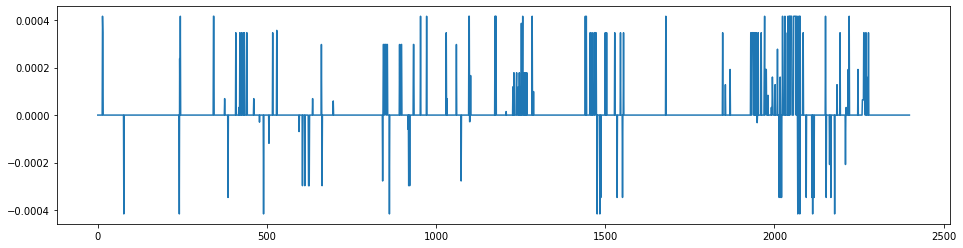

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
# plt.plot(my_scores)
# plt.plot(arai_scores)
plt.plot(np.array(kkiller_scores) - np.array(my_scores))
# plt.xlim((500, 1000))

In [65]:
np.sum(my_scores), np.sum(kkiller_scores), np.sum(arai_scores)

(0.6788486235986236, 0.7112332793840146, 0.6881008007515361)

In [66]:
submission.to_csv('./merge.csv')